In [241]:
import numpy as np
import scipy as sp

This is a notebook to study the work of 

In [ ]:

def G_sigma(x:float,sigma:float)-> float:
    """
    Kernel function for KDE estimation of 
    probability density. Kernel is assumed to be stationary and rely
    on a single bandwith (sigma). Note that this is a one dimensional
    distribution. 

    Parameters:
    ----------
    x: float: value to evaluate kernel at
    sigma: float: Bandwith. Assumed to be positive. 

    Outputs:
    -------
    float: Function evaluation at x.
    """
    return np.exp(-(x/sigma)**2/2)

def predict(x,P,A,Q):
    return A@x,A@P@A.T+Q

def form_d_W(x:np.array,y:np.array,P:np.array,
             R:np.array,H:np.array)-> (np.array,np.array,np.array,np.array):
    """
    Helper function to form displacement vector (d) 
    and weight array W. Also forms the inverse of the Cholesky
    factorization of the covariance of the state and measurement for 
    future use.

    Parameters:
    ----------
    x: np.array: Current best estimate for the state 
        of the system at step k given measurements up
        until step k-1
    y: np.array: Measurement at step k
    P: np.array: Covariance estimate for state at step k
        given info up to step k-1
    R: np.array: Covariance measurement of measurement error
    H: np.array: Measurement Operator

    Outputs:
    -------
    d: np.array: Displacement vector
    W: np.array: Weight array
    Theta_p_inv: np.array: Inverse of cholesky factorization of 
        state covariance.
    Theta_R_invnp.array: Inverse of cholesky factorization of 
        measurement covariance.
    """
    m = len(x)
    n = len(y)
    #TODO: Experiencing a Numerical Instability in the robust version. 
    Theta_p = np.linalg.cholesky(P)
    Theta_R = np.linalg.cholesky(R)
    Theta_p_inv = np.linalg.pinv(Theta_p)
    Theta_R_inv = np.linalg.pinv(Theta_R)
    d = np.zeros(m+n)
    W = np.zeros((n+m,m))
    d[:m] = Theta_p_inv@x
    d[m:] = Theta_R_inv@y
    W[:m,:] = np.eye(m)
    W[m:,:] = H
    return d,W,Theta_p_inv,Theta_R_inv

def select_sigma(d:np.array,W:np.array,n:int)-> float:
    """
    Procedure to select bandwith for kernel. Performs a heursitic
    where beta is first fixed and then the boundedness condition is 
    ignored. This may be a problem, but is an initial approach. After 
    selecting the ke 

    Parameters:
    ----------
    d:np.array: Displacement (d) vector
    W: np.array: Weight matrix
    n: Dimension of ambient state space

    Outputs:
    -------
    sigma:float: Acceptable bandwith for convergence
    """
    L,N = W.shape
    num_val = 0
    Q = np.zeros((N,N))
    for k in range(L):
        wk = W[k,:]
        dk = d[k]
        for j in range(k):
            num_val += sum(abs(wk-W[j,:]))*np.abs(dk-d[j])
            Q += np.outer(wk-W[j,:],wk-W[j,:])
    lmin = np.linalg.eigvalsh(Q)[0]
    rho = np.sqrt(N)*num_val/lmin
    beta = 2*rho

    gamma = 0
    for k in range(L):
        wk = W[k,:]
        dk = d[k]
        for j in range(k):
            wjk = sum(abs(wk-W[j,:]))
            njk = max(abs(wk-W[j,:]))*wjk
            djk = abs(dk-d[j])
            gamma+= (beta*wjk+djk)*wjk*(beta*njk+djk+wjk)

    def psi(sigma,beta,gamma,n,W,d):
        L,N = W.shape
        Q = np.zeros((N,N))
        for k in range(L):
            wk = W[k,:]
            dk = d[k]
            for j in range(k):
                Q+=G_sigma(x=beta*sum(abs(wk-W[j,:]))+abs(dk-d[j]),sigma=sigma)*np.outer(wk-W[j,:],wk-W[j,:])
        lmin = np.linalg.eigvalsh(Q)[0]
        psi = np.sqrt(n)*gamma/(2*lmin*sigma**2)
        return psi
    
    sigma = 1.07*np.power(N,-1/5)
    while psi(sigma,beta,gamma,n,W,d) >= 1:
        sigma = sigma*1.1 
    return sigma
 
def form_K(x:np.array,d:np.array,W:np.array,Theta_p_inv:np.array,
           Theta_R_inv:np.array,H:np.array,sigma:float)-> np.array:
    """
    Helper function to find Kalman gain given the current state of the 
    system. 

    Parameters:
    ----------
    x:np.array: Current estimate of x at state k given all information 
        up to state k.
    d:np.array: Displacement vector.
    W:np.array: Weight matrix
    Theta_p_inv: Inverse of cholesky factorization of 
        state covariance estimate
    Theta_R_inv: Inverse of cholesky factorization of 
        measurement covariance estimate. 

    Outputs:
    --------
    K: np.array: Current Kalman gain estimate. 

    """
    e = d-W@x
    L = len(e)
    psi = [sum([G_sigma(e[i]-e[k],sigma) for k in range(L)]) for i in range(L)]
    Psi =np.diag(psi)
    Phi = np.zeros((L,L))
    for count,_ in np.ndenumerate(Phi):
        Phi[count] = G_sigma(e[count[0]]-e[count[1]],sigma)
    Delta = Psi-Phi
    m = len(x)
    P_tilde = Theta_p_inv@Delta[:m,:m]@Theta_p_inv
    P_xy_tilde = Theta_R_inv@Delta[m:,:m]@Theta_p_inv
    P_yx_tilde = Theta_p_inv@Delta[:m,m:]@Theta_R_inv
    R_tilde = Theta_R_inv@Delta[m:,m:]@Theta_R_inv
    K = np.linalg.pinv(P_tilde+H.T@P_xy_tilde+P_yx_tilde@H + H.T@R_tilde@H)@(P_yx_tilde+H.T@R_tilde)
    return K

def form_K_Robust(x:np.array,d:np.array,W:np.array,Theta_p_inv:np.array,
                  Theta_R_inv:np.array,H:np.array,sigma:float)->np.array:
    L,m = W.shape
    e = d-W@x
    psi = [sum([G_sigma(e[i]-e[k],sigma) for k in range(L)]) for i in range(L)]
    Psi =np.diag(psi)
    Phi = np.zeros((L,L))
    for count,_ in np.ndenumerate(Phi):
        Phi[count] = G_sigma(e[count[0]]-e[count[1]],sigma)
    Omega = Psi.T@Psi+Phi.T@Phi
    P_yx_tilde = Theta_p_inv@Omega[:m,m:]@Theta_R_inv
    R_tilde = Theta_R_inv@Omega[m:,m:]@Theta_R_inv
    K = np.linalg.solve((W.T@Omega@W),(P_yx_tilde+H.T@R_tilde))
    return K

def update_in_loop(x:np.array,x_minus:np.array,y:np.array,H:np.array,
                   d:np.array,W:np.array,Theta_p_inv:np.array,
                   Theta_R_inv:np.array,sigma:float)-> (np.array,np.array):
    K_new = form_K_Robust(x,d,W,Theta_p_inv,Theta_R_inv,H,sigma)
    x_new = x_minus+K_new@(y-H@x_minus)
    return x_new,K_new

def iteration_scheme(x:np.array,x_minus:np.array,y:np.array,H:np.array,
                     d:np.array,W:np.array,Theta_p_inv:np.array,
                     Theta_R_inv:np.array,sigma:float,tol=1e-5,max_iters=1000)-> (np.array,np.array):
    for iter in range(max_iters):
        x_new,K_new = update_in_loop(x,x_minus,y,H,d,W,Theta_p_inv,Theta_R_inv,sigma)
        if (np.linalg.norm(x_new-x)/np.linalg.norm(x_new))<tol:
            x = x_new
            break
        else:
            x=x_new
    return x,K_new

def update_full(x:np.array,y:np.array,P:np.array,H:np.array,R:np.array,
                sigma:float,tol=1e-5,max_iters=1000)-> (np.array,np.array):
    d,W,Theta_p_inv,Theta_R_inv = form_d_W(x,y,P,R,H)
    if not(sigma):
        sigma = select_sigma(d,W,n=len(x))
    x_new,K_new = iteration_scheme(x=x,x_minus=x,y=y,H=H,d=d,W=W,Theta_p_inv=Theta_p_inv\
                                   ,Theta_R_inv=Theta_R_inv,sigma=sigma,tol=tol,max_iters=max_iters)
    n = len(x_new)
    B = np.eye(n)-K_new@H
    P_new = B@P@B.T + K_new@R@K_new.T
    return x_new,P_new

def entropy_Kalman_procedure(x0:np.array,P0:np.array,Y:np.array,H:np.array,
                             A:np.array,R:np.array,Q:np.array,tol=1e-5,
                             max_iters=1000,sigma=None)->(np.array,np.array,np.array):
    obs_dim,steps = Y.shape
    output_series = np.zeros((obs_dim,steps))
    output_uncertainty = np.zeros((obs_dim,steps))
    P_uncertainty = np.zeros((P0.shape[0],steps))
    x = x0
    P = P0
    for step in range(steps):
        x,P = predict(x,P,A,Q)
        output_series[:,step] = H@x
        output_uncertainty[:,step] = np.sqrt(np.diag(H@P@H.T+R))
        curr_measurement = Y[:,step]
        x,P = update_full(x,curr_measurement,P,H,R,tol=tol,max_iters=max_iters,sigma=sigma)
        print(P)
        P_uncertainty[:,step] = np.sqrt(np.diag(P))

    return output_series, output_uncertainty, P_uncertainty

def Kalman_gain(P:np.array,H:np.array,R:np.array)->np.array:
    S = sp.linalg.pinvh(H@P@H.T+R)
    K = P@H.T@S
    return K
def Kalman_update(x:np.array,y:np.array,P:np.array,R:np.array,H:np.array)->(np.array,np.array):
    n = len(x)
    d = y-H@x
    K = Kalman_gain(P,H,R)
    x_new = x+K@d
    P_new = (np.eye(n)-K@H)@P@(np.eye(n)-K@H).T + K@R@K.T
    return x_new,P_new

def Kalman_Procedure(x0:np.array,Y:np.array,P0:np.array,R:np.array,
                     H:np.array,A:np.array,Q:np.array)->(np.array,np.array,np.array):
    obs_dim,steps = Y.shape
    output_series = np.zeros((obs_dim,steps))
    output_uncertainty = np.zeros((obs_dim,steps))
    P_uncertainty = np.zeros((P0.shape[0],steps))
    x = x0
    P = P0
    for step in range(steps):
        x,P = predict(x,P,A,Q)
        output_series[:,step] = H@x
        output_uncertainty[:,step] = np.sqrt(np.diag(H@P@H.T+R))
        curr_measurement = Y[:,step]
        x,P = Kalman_update(x,curr_measurement,P,R,H)
        P_uncertainty[:,step] = np.sqrt(np.diag(P))

    return output_series, output_uncertainty, P_uncertainty

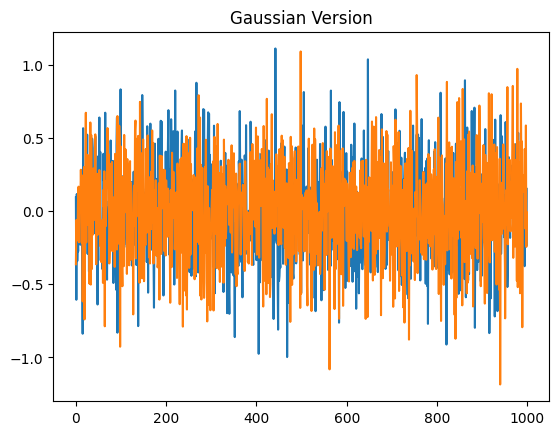

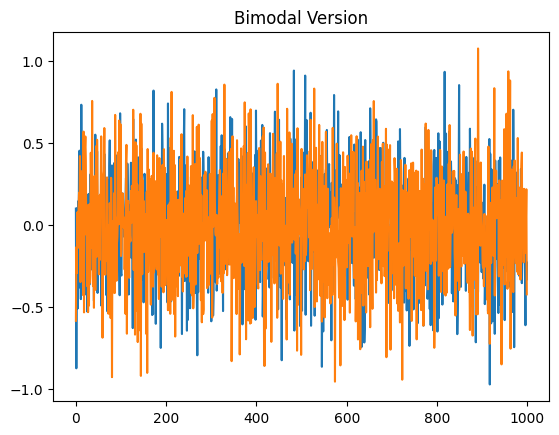

In [242]:
import matplotlib.pyplot as plt
delay = 10
n = 2
steps = 1000
def sample_unit_var_bimodal(n):
    vec = np.zeros(n)
    for l in range(n):
        acc = np.random.random()
        if acc<= 1/2:
            vec[l] = (np.random.randn()+np.sqrt(255))/16
        if acc>1/2:
            vec[l] = (np.random.randn()-np.sqrt(255))/16
    return vec
def random_model(delay,n):
    return np.random.randn(delay*n,delay*n)
def random_cov(N,k):
    C = np.zeros((N,N))
    for j in range(k):
        random_vec = np.random.randn(N)
        C+= np.outer(random_vec,random_vec)
    return C/np.sqrt(k)

def bimodal_random_trajectory(x0,A,L_Q,L_R,steps,H):
    m,n = H.shape
    time_series = np.zeros((m,steps))
    x = x0
    for step in range(steps):
        time_series[:,step] = H@x +L_R@sample_unit_var_bimodal(m)
        x = A@x + L_Q@sample_unit_var_bimodal(n)
    return time_series

def gaussian_random_trajectory(x0,A,L_Q,L_R,steps,H):
    m,n = H.shape
    time_series = np.zeros((m,steps))
    x = x0
    for step in range(steps):
        time_series[:,step] = H@x +L_R@np.random.randn(m)
        x = A@x + L_Q@np.random.randn(n)
    return time_series

A = random_model(delay=delay,n=n)
_,s,_ = np.linalg.svd(A)
A = A/max(s)*0.9
Q = random_cov(delay*n,2*delay*n)/100
R = random_cov(n,2*n)/100
H = np.zeros((n,delay*n))
H[:,-n:] = np.eye(n)
L_Q = np.linalg.cholesky(Q)
L_R = np.linalg.cholesky(R)
x0 = np.random.randn(delay*n)

series = gaussian_random_trajectory(x0=x0,A=A,L_Q=L_Q,L_R=L_R,steps=steps,H=H)
plt.plot(series[0,:],label="First Coordinate")
plt.plot(series[1,:],label="Second Coordinate")
plt.title("Gaussian Version")
plt.show()
series = bimodal_random_trajectory(x0=x0,A=A,L_Q=L_Q,L_R=L_R,steps=steps,H=H)
plt.plot(series[0,:],label="First Coordinate")
plt.plot(series[1,:],label="Second Coordinate")
plt.title("Bimodal Version")
plt.show()


In [243]:
series = bimodal_random_trajectory(x0=x0,A=A,L_Q=L_Q,L_R=L_R,steps=steps,H=H)

In [244]:
output_series,output_uncertainty,P_uncertainty = entropy_Kalman_procedure(x0=np.random.randn(delay*n),P0=np.eye(delay*n)*1000,
                                                                          Y=series,H=H,A=A,R=R,Q=Q,sigma=0.01,max_iters=100)
plt.plot(output_series[0,:],label="Filtered")
plt.plot(series[0,:],label="True",alpha=0.6)
plt.legend()
plt.title("Filter vs True")
plt.show()

[[ 2.20616726e+02 -6.05357496e+01 -5.76592556e+00  1.58821309e+01
  -2.06614540e+01  5.60653453e-01  1.94859856e+01  7.51661999e+01
   1.55467940e+01 -2.99870533e+01  5.10817548e+01 -6.49355075e+01
   6.11239393e+01  1.74530759e+01 -9.27068885e+01  8.83973355e+01
   4.28204772e+01 -5.39016440e+01  1.25018105e+03 -1.08727669e+03]
 [-6.05357496e+01  2.17299694e+02  2.87158571e+01 -1.76917413e+01
  -1.82950444e+01 -7.63353186e+01 -1.79745636e+01 -2.20211734e+01
  -2.62972424e+01 -3.98447412e+01  2.19116496e+00  6.21309158e+01
   9.48076433e+00 -4.39075082e+01 -4.11564026e+01 -6.25991378e+00
  -3.70925877e+01  4.19530852e+01 -7.15477975e+02  9.16039288e+02]
 [-5.76592556e+00  2.87158571e+01  2.65318157e+02  1.01402953e+01
  -2.51224666e+01  3.93884044e+01  1.72437545e+02  6.85794596e+01
   6.32237589e+01 -4.58995986e+01 -3.38003161e+01 -3.46909192e+00
  -2.57733623e+01 -1.11141964e+02 -2.17960711e+01 -4.77186949e+01
   7.69788281e+00 -7.59734121e+01 -2.71400043e+02  2.32702098e+03]
 [ 1.58

LinAlgError: Matrix is not positive definite

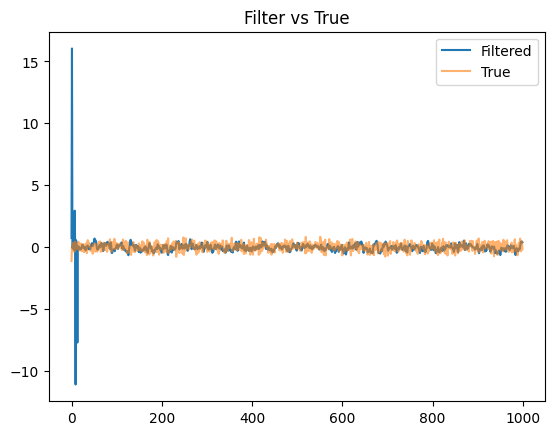

In [ ]:
plt.plot(output_series[0,:],label="Filtered")
plt.plot(series[0,:],label="True",alpha=0.6)
plt.legend()
plt.title("Filter vs True")
plt.show()

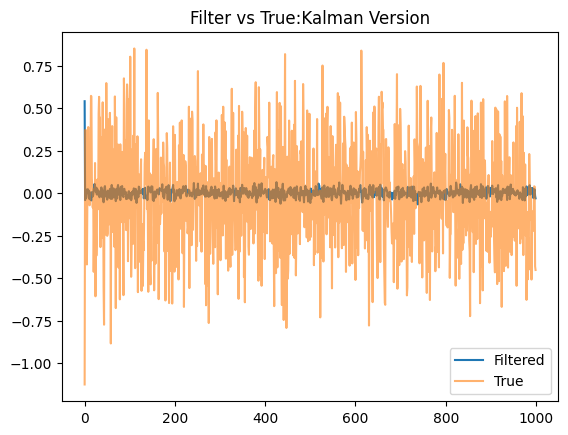

In [239]:
output_series_K,output_uncertainty_K,P_uncertainty_K = Kalman_Procedure(x0=np.random.randn(delay*n),Y=series,P0=np.eye(delay*n),
                                                                        R=R,H=H,A=A,Q=Q)
plt.plot(output_series_K[0,:],label="Filtered")
plt.plot(series[0,:],label="True",alpha=0.6)
plt.legend()
plt.title("Filter vs True:Kalman Version")
plt.show()

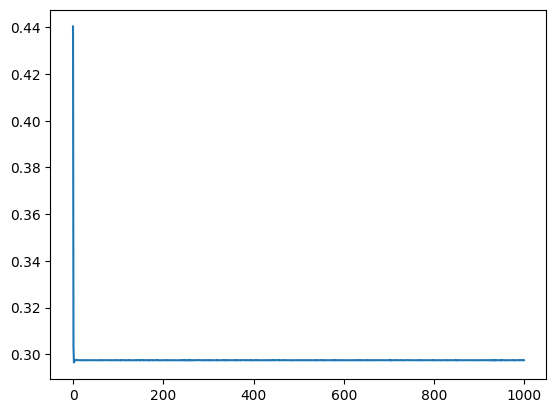

In [134]:
plt.plot(output_uncertainty[0,:])
plt.show()

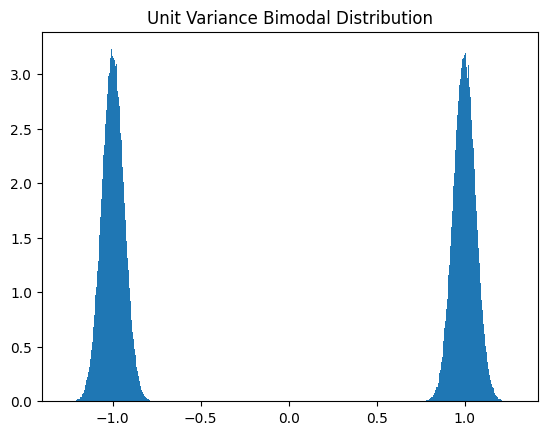

1.0001444521340008


In [141]:
X = np.array([sample_unit_var_bimodal(1)[0] for n in range(1000000)])
import matplotlib.pyplot as plt
plt.hist(X,bins=1000,density=True)
plt.title("Unit Variance Bimodal Distribution")
plt.show()
print(np.average(X**2))